#オンライン・コンテンツ4.4 進化動学をプログラムする

図斎　大

このPythonコードは，浅古泰史・図斎大・森谷文利『活かすゲーム理論』有斐閣の第４章までを読んだ読者を対象としたオンライン・コンテンツです。ここではオンライン・コンテンツ4.3で取り上げた3つの進化動学（模倣＝複製子動学、標準的な最適反応動学、緩和された最適反応動学tBRD）をPythonのコードにします。なんらかのビジュアルで結果を出すのですが、オンライン・コンテンツ4.3で解説したように、エージェントが無限にいることを想定した微分方程式での遷移ベクトルを図示した位相図をまず描きます。そこでは進化動学を戦略分布の変化として集計的に見ています。しかしその背後には、個々人がなんらかのルールに従って戦略を改訂していると考えられます。この個々人の戦略改訂を直接コンピュータ上でシミュレーションする（agent based simulation）というのをこのコードの後半で扱います。

Pythonについてクラスの定義まで基礎的なことを知っていれば、以下のコードを読めるでしょう。そのようなPython自体についての解説は、軽重様々なわかりやすい入門書がプログラミングの専門家によって書かれているので、そちらを参照してください。軽めの入り口として『Pythonの絵本』（著：株式会社アンク、出版：翔泳社）、もう少ししっかり目では『スッキリわかるPython入門』（著：国本・須藤、出版：インプレス）が私の知っている中で適当なものです。以下のコード中の解説では、そのような基礎知識（クラスやインスタンスといったオブジェクト指向の基礎的な知識、MatplotLibによる描画）を前提として、進化動学をどうPythonのコードで表現するかということに焦点を当てています。コードの中で読み手の皆さんが適宜数字などを変えられる変数（パラメータ）を、解説の中では**太字**で表します。

またこの.ipynbファイルは、そのまま実行可能なJupyter notebookとして書かれています。特に、Googleのアカウントを持ってさえいれば、Google Colaboratory https://colab.research.google.com/
にこのファイルをアップロードすれば、そのまま実行可能です。以下で、コードが書かれているセルをマウスで触れると実行ボタン（黒丸の地に右向きの白三角▷）が出てくるので、読み進めるとともにそれを順次押してみてください。（途中で実行し損ねのセルがあるとうまくいきません。）あるいは、タブのなかの「ランタイム」から「すべてのセルを実行」できます。そして説明の中で黒字にしているものは、パラメータに相当し、説明に続くセルの中で該当する部分の数字などを適宜変えて構わないところです。

ちなみに、このコードでは、各種の進化動学について、その背後にある意思決定原理をまず（大本のクラスとして）定義し、その一つの原理から派生する形で、微分方程式の位相図を描くための集団レベルと、シミュレーションで軌道を描くための個々人を（サブクラスとして）対比的に定めています。このいずれかのレベルにのみを扱うなら、少し単純なコードになります。

#準備
##必要なpackageのimport

In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np

## ゲームの設定
ここでは、本書第４章でモデル4.1として与えているゲームを考えています。strgSetは0（PoyPoyを使わない）,1（使う）の2戦略のリスト。payMatは行を自分の戦略、列を相手の戦略とする自分の利得の行列を与えています。（使わないのが最初の戦略（最初のインデックス0に相当）になるので、表4-1とは天地左右が逆さになります。）つまり、自分の戦略を第1引数ownStrg、相手の戦略を第2引数oppStrgに入れると、payMat[ownStrg][oppStrg]がこの戦略の組の下での自分の利得となります。
* 他のゲームを試してみたければ、この**payMat**の利得行列を変えてみてください。ただしプレーヤーも戦略も2つであることは、第4章のように2次元上のグラフで戦略分布を表現するための前提となります。以下では、2つのプレーヤーが、同じ利得行列を用いています。異なる利得行列とするのはさほど大変ではないので、コードの理解を確認するための課題として読者の皆さんにお任せします。
* 進化動学の中にはスイッチングレートが、変更先の戦略の利得や変更による利得の改善幅に比例するものがあります。個々人レベルのシミュレーションを行うときにこのスイッチングレートを（単なる戦略改訂の速さではなく）戦略を変える確率としても用いるときに、それが1を超えるとまずいです。なので、利得や利得差としてありえる最大値をここで求めておきます。そして利得・利得差からスイッチングレートを導くときに、この最大値で除しておくことでスイッチングレートが1を超えないようにします。

In [2]:
strgSet=[0,1]
payMat=[[1,0],[-1,3]] #payMat[ownStrg][oppStrg]
maxPay=np.max(payMat);maxPayDiff=(np.max(payMat)-np.min(payMat))

## "PlayerRole"クラスを定義
このクラスのインスタンスに、各プレーヤーの「役割」がどんなものか、つまり戦略集合や利得関数の情報を保持させます。のちにこのクラスを継承する形で、集計したプレーヤーや、このプレーヤーの役を割り振ったエージェントを作っていきます。
### 属性
* strgSet: 取りうる戦略の集合(instantiaionのときに引数として与える。)
* payMat: 利得行列(instantiaionのときに引数として与える。)
* nmStrg: 取りうる戦略の個数（strgSetの要素の数として計算）
* revProt: switching costを導く関数（後述のIoSなどを代入する）

### メソッド
* expPayFn(strgDist_opp):相手の戦略分布strgDist_oppを与えられたもとで、自らの各戦略の期待利得を計算し、それらを集めた利得ベクトルを出力。

In [3]:
class PlayerRole():
    # Constructor
    def __init__(self,strgSet,payMat,revProt):
        self.strgSet = strgSet
        self.payMat = payMat
        self.nmStrg =len(self.strgSet)
        self.revProt = revProt
    def expPayFn(self,strgDist_opp):
        payVec = [ 0 for strgId in range(self.nmStrg)]
        for strgId in range(self.nmStrg):
            for strgId_opp in range(len(strgDist_opp)):
                payVec[strgId] += self.payMat[strgId][strgId_opp]*strgDist_opp[strgId_opp]
        return payVec

## 進化動学: 利得からスイッチングレートを導く関数として
このコードではIoS(成功の模倣)、stdBRD(標準的な最適反応動学)、tBRD(緩和された最適反応動学)の３つを準備しています。それぞれ現在の利得ベクトルpayVecを引数として与えたもとで、戦略間のスイッチングレートを計算し、現在の戦略を最初のインデックス、次の戦略候補を第２のインデックスとする行列として出力する関数になっています。この関数がそれぞれの進化動学を表します。
* IoSに関してはオンライン・コンテンツ4.3で触れたように、スイッチングレートが負にならないように、利得に定数項を足したものを考えることがあります。その定数項だけのバリエーションがあるので、まずはクラスとして定義。そして定数項をpayAddとしてインスタンスを生むときの引数にしています。たとえばIoS(1)で定数項を1とする「成功の模倣」を表し、それがpayVecからスイッチングレートの行列を導く関数として働くようになっています（このインスタンスを呼び出したときに、そのような関数になります）。




In [4]:
#switching rate under Imitation of Success
class IoS():
    def __init__(self,payAdd = 0):
        self.payAdd=payAdd
    def __call__(self,payVec,strgDist_own):
        strgIdSet = range(len(payVec))
        switchMtrx = [ [ 0 for strgIdTo in strgIdSet] for strgIdFrom in strgIdSet]
        for strgIdFrom in strgIdSet:
            tempVec=[ 0 for strgIdTo in strgIdSet]
            for strgIdTo in [strgId for strgId in strgIdSet if strgId !=strgIdFrom]:
                tempVec[strgIdTo] = strgDist_own[strgIdTo]*(payVec[strgIdTo]+self.payAdd)/(maxPay+self.payAdd)
            switchMtrx[strgIdFrom] = tempVec
            switchMtrx[strgIdFrom][strgIdFrom] = 1- sum(tempVec)
        return switchMtrx

#switching rate under standard BRD
def stdBRD(payVec,strgDist_own):
    strgIdSet = range(len(payVec))
    switchMtrx = [ [ 0 for strgIdTo in strgIdSet] for strgIdFrom in strgIdSet]
    maxPay=max([payVec[strgId] for strgId in strgIdSet])
    maxStrgIndx=[strgId for strgId in strgIdSet if payVec[strgId]==maxPay]
    for strgIdFrom in strgIdSet:
        for strgIdTo in maxStrgIndx:
            switchMtrx[strgIdFrom][strgIdTo] = 1/len(maxStrgIndx)
    return switchMtrx

#switching rate under tempered BRD
def tBRD(payVec,strgDist_own):
    strgIdSet = range(len(payVec))
    switchMtrx = [ [ 0 for strgIdTo in strgIdSet] for strgIdFrom in strgIdSet]
    maxPay=max([payVec[strgId] for strgId in strgIdSet])
    maxStrgId=[strgId for strgId in strgIdSet if payVec[strgId]==maxPay]
    for strgIdFrom in strgIdSet:
        tempVec=[ 0 for strgIdTo in strgIdSet]
        for strgIdTo in [strgId for strgId in maxStrgId if strgId !=strgIdFrom]:
            tempVec[strgIdTo] = (maxPay - payVec[strgIdFrom])/(maxPayDiff*len(maxStrgId))
        switchMtrx[strgIdFrom] = tempVec
        switchMtrx[strgIdFrom][strgIdFrom] = 1- sum(tempVec)
    return switchMtrx

### 動学の選択
以上で定義した関数＝進化動学の中から、このコードを実行するときに用いるものを選び、それを**dyn**に割り当てます。**IoS**については定数項の値を引数に入れます(IoSクラスのインスタンスとして関数が生成されます)。

In [5]:
dyn=tBRD #dyn=IoS(1); dyn=stdBRD

#集計レベルでの位相図の描画
直接、進化動学の微分方程式をもとに各プレーヤーの遷移ベクトルを求めます。


## 各プレーヤーを集計レベルで表すクラス
PlayerRoleを継承するサブクラスとして定義。

* 属性と引数: PlayerRoleと同じ。
* メソッド aggTrans: 自他の戦略分布を引数に与えたもとで、自らの戦略分布の遷移ベクトルを導きます。
*メソッド aggTrans_binary: ２戦略だけなら戦略分布も遷移ベクトルも、一つの戦略について定めれば、他方の戦略についても決まります。それゆえに、aggTransの引数も出力も、戦略"1"(PoyPoyを使う)のシェアのみに縮約したものです。

In [6]:
class AggPlayer(PlayerRole):
    #Calculate a transition vector in the aggregate (mean) dynamic
    def aggTrans(self,strgDist_own,strgDist_opp):
        nmStrg=len(self.strgSet)
        payVec_current = self.expPayFn(strgDist_opp)
        switchMtrx = self.revProt(payVec_current,strgDist_own)
        transVec = [0 for strgId in range(nmStrg)]
        for strgIdFrom in range(nmStrg):
            for strgIdTo in range(nmStrg):
                flow = strgDist_own[strgIdFrom]*switchMtrx[strgIdFrom][strgIdTo]
                transVec[strgIdTo] += flow
                transVec[strgIdFrom] += -flow
        return transVec
    def aggTrans_binary(self,strg1Share_own,strg1Share_opp):
        transVec=self.aggTrans([1-strg1Share_own,strg1Share_own],[1-strg1Share_opp,strg1Share_opp])
        return transVec[1]

## 位相図を描く準備
### 遷移ベクトルを求める点のグリッドを設定
**gridUnit**でグリッドの間隔を設定します。ここでは0.05。つまり、p,qともに0.05の倍数ごとに０から１まで、つまり(p,q)=(0,0), (0.05, 0), (0.10, 0),...,(0.95,0), (1, 0), (0,0.05), (0.05, 0.05),..., (0.95,1), (1,1)という各点で遷移ベクトルを求めます。

In [7]:
gridUnit=0.05 #グリッドの間隔
pRange = np.arange(0,1+gridUnit,gridUnit)#縦軸上(p)の方眼の値
qRange = np.arange(0,1+gridUnit,gridUnit)#横軸上(q)の方眼の値
pGrid, qGrid = np.meshgrid(pRange, qRange)# 方眼を作成

## phasePlot: 2Dの矢印プロットを描画する関数
### 入力
* dPFn: 点(p,q)を与えたときに、その点でのpの遷移を導く関数
* dQFn: 点(p,q)を与えたときに、その点でのqの遷移を導く関数.（ただし、q自らが第１引数となるようにdQFn(q,p)と、pとqを逆さにします。)

### 出力
グリッド上の各点で(p,q)の遷移ベクトルを矢印でプロット。（このプロットが関数の返り値。）ただし定常点と判断したところは、矢印ではなく黒点をプロット。各点(p,q)においてdpFnとdQFnから導いた遷移ベクトル(dPFn(p,q),dQFn(q,p))の長さを計算し、それが閾値**stopThresh**よりも小さければ、この点(p,q)を定常点だと判断します。

つまりphasePlot(dPFn,dQFn)で、先に準備したグリッドの各点でdpFnとdQFnから導いた遷移ベクトル(dPFn(p,q),dQFn(q,p))をプロットします。


In [8]:
def phasePlot(dPFn,dQFn):
    #Calculate a transition vector and scale it down
    dP=[[0 for qId in range(len(pRange))]for pId in range(len(pRange))]
    dQ=[[0 for qId in range(len(pRange))]for pId in range(len(pRange))]
    dNorm=[[0 for qId in range(len(pRange))]for pId in range(len(pRange))]
    statP=[];statQ=[]
    stopThresh=0.0000001
    for pId in range(len(pRange)):
        for qId in range(len(pRange)):
            p=pGrid[pId][qId];q=qGrid[pId][qId]
            dp=dPFn(p,q);dq=dQFn(q,p)
            dNorm[pId][qId] = np.sqrt(pow(dp,2)+pow(dq,2))
            if dNorm[pId][qId]<stopThresh:
                dP[pId][qId] = 0
                dQ[pId][qId] = 0
                dNorm[pId][qId] = 0
                statP.append(p);statQ.append(q)
            else:
                dP[pId][qId] = dp/dNorm[pId][qId]
                dQ[pId][qId] = dq/dNorm[pId][qId]
    plt.quiver(pGrid, qGrid, dP, dQ,dNorm, cmap='gnuplot2',scale=1/(0.9*gridUnit), width=0.2*gridUnit)
    plt.scatter(statP,statQ,c='k')

##実際の描画
まず、AggPlayerクラスにこのゲームの設定strgSet, payMatと選択した動学dynを与えたもとでのインスタンスとして、「お客」「お店」それぞれを集計レベルで表すaggCust, aggShopを作ります。そしてそれらに関してaggTrans_binaryによりp,qの遷移を計算する関数を呼び出したうえで、phasePlotによって遷移ベクトルをプロットさせ、fig1に収めます。

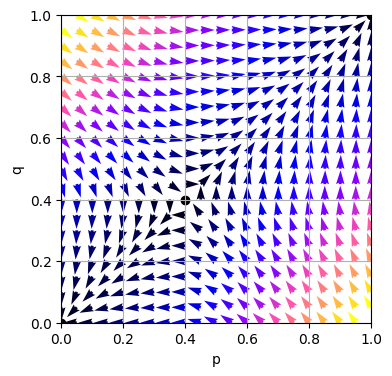

In [9]:
aggCust=AggPlayer(strgSet,payMat,dyn)
aggShop=AggPlayer(strgSet,payMat,dyn)
plt.figure(figsize=(4, 4)) # 図の設定
plt.xlabel('p') # x軸ラベル
plt.ylabel('q') # y軸ラベル
plt.xlim(0,1); plt.ylim(0,1)
phasePlot(aggCust.aggTrans_binary,aggShop.aggTrans_binary)
plt.grid() # グリッド線
plt.show()

# 個々人レベルのシミュレーション


## 個人を表すclassを定義
シミュレーションの中の「個人」を表すインスタンスを生むクラスとして、Agentクラスを定義します。PlayerRoleクラスを継承し、以下の属性とメソッドを追加します。
* 属性 StrgId：この個人がいま取っている戦略を、StrgSetの中の何番目なのかを指定。(最初に取る戦略を引数initStrgIdで、インスタンスを生むときに与えます。)
* メソッド updateStrg: 各個人はrev_prob=0.01の確率で戦略改訂の機会を各期初に得ます。この機会を得た時に、このメソッドの引数switchProbVecで与えた確率分布（戦略の数だけの次元の確率ベクトル）に従って、次の戦略を選び、それへと自らのStrgIdを更新します。


In [10]:
class Agent(PlayerRole):
    rev_prob = 0.01
    def __init__(self,strgSet,payMat,revProt,initStrgId):
        super().__init__(strgSet,payMat,revProt)
        self.strgId= initStrgId
    def updateStrg(self,switchProbVec):
        if random.uniform(0,1) < self.rev_prob:
            self.strgId = np.random.choice(a=range(len(self.strgSet)),p=switchProbVec)

## 各プレーヤー役ごとに個々人を集めるクラスを定義
やはりPlayerRoleを継承し、次の属性とメソッドを追加。
* 属性 agentsList: このグループに属する個人のリスト
* メソッド generateAgents: まず各戦略ごとにそれを最初に取る個人を何人生むかという人数を指定し、それを並べたリストを引数initNumAgentsByStrgに与えた下で、それに従ってAgentクラスのインスタンスとして「個人」を生成し、そしてその個々人を集めたものをagentsListに収めます。
* メソッド strgDist_calc: 現在のagentsListの中での戦略分布を計算し、リストとして出力。
* メソッド agentsUpdateStr: 現在の自他のプレーヤー役ごとの戦略分布を引数strgDist_own,strgDist_oppに与えた下で、各戦略の期待利得・スイッチングレートを計算し、そのスイッチングレートに従い、自らのagentsListの各個人の戦略をその個人のupdateStrgによって改訂させます。

In [11]:
class AgentPop(PlayerRole):
    def __init__(self,strgSet,payMat,revProt):
        super().__init__(strgSet,payMat,revProt)
        self.agentsList = []
    def generateAgents(self,initNumAgentsByStrg):
        for strgId in range(len(strgSet)):
            self.agentsList +=[ Agent(self.strgSet,self.payMat,self.revProt,strgId)\
                          for i in range(initNumAgentsByStrg[strgId])]
    def strgDist_calc(self): # aggregating agents' strtgategies to a (joint) strtgategy distrtgibution
        numAgentsByStrg = [0 for strgId in range(len(self.strgSet))]
        strgDist = [0 for strgId in range(len(self.strgSet))]
        for agent in self.agentsList:
            numAgentsByStrg[agent.strgId] += 1 #Simply counting the number of players of each strtg
        for strgId in range(len(self.strgSet)):
            strgDist[strgId] = numAgentsByStrg[strgId]/len(self.agentsList) #Divide by the number of all agents to make it a prob dist
        return strgDist
    def agentsUpdateStrg(self,strgDist_own,strgDist_opp):
        #nmStrg=len(self.strgSet)
        payVec_current = self.expPayFn(strgDist_opp)
        switchMtrx = self.revProt(payVec_current,strgDist_own)
        for agent in self.agentsList:
            agent.updateStrg(switchMtrx[agent.strgId])

##シミュレーションを実行する関数
(initCustStrg1Share,initShopStrg1Share)で、お客・お店の"In"のシェアの初期値を与えたもとで、そこからの個々人レベルのシミュレーションを行います。そして予め用意しておいた座標平面上に軌跡をプロットする。
**numAgents**で各プレーヤー役ごとのエージェントの数、また**numDays**でシミュレーションを行う期間（期の数）を設定します。

In [12]:
def singleRun(initCustStrg1Share,initShopStrg1Share):
    numAgents=1000
    initNumCustByStrg=[0,0]
    initNumCustByStrg[1]=round(numAgents*initCustStrg1Share)
    initNumCustByStrg[0]=numAgents-initNumCustByStrg[1]
    initNumShopByStrg=[0,0]
    initNumShopByStrg[1]=round(numAgents*initShopStrg1Share)
    initNumShopByStrg[0]=numAgents-initNumShopByStrg[1]

    numDays=1000

    custPop=AgentPop(strgSet,payMat,dyn)
    shopPop=AgentPop(strgSet,payMat,dyn)
    custPop.generateAgents(initNumCustByStrg)
    shopPop.generateAgents(initNumShopByStrg)
    custStrgDistCurrent = custPop.strgDist_calc()
    shopStrgDistCurrent = shopPop.strgDist_calc()
    custStrg1ShareHist = [custStrgDistCurrent[1]]
    shopStrg1ShareHist = [shopStrgDistCurrent[1]]

    #Now run the simulation
    for day in range(numDays):
        custPop.agentsUpdateStrg(custStrgDistCurrent,shopStrgDistCurrent)
        shopPop.agentsUpdateStrg(shopStrgDistCurrent,custStrgDistCurrent)

        custStrgDistCurrent = custPop.strgDist_calc()
        shopStrgDistCurrent = shopPop.strgDist_calc()
        custStrg1ShareHist.append(custStrgDistCurrent[1])
        shopStrg1ShareHist.append(shopStrgDistCurrent[1])

    plt.plot(custStrg1ShareHist,shopStrg1ShareHist,c='k',linewidth=2)

##座標平面を用意し、シミュレーションを実行し軌跡を描画する
先ほど定義した**singleRunの引数**に、初期分布を与えてシミュレーションを実行します。ここでは、(p,q)=(0.6,0.25), (0.25,0.6), (0.2,0.55), (0.55,0.2)の4つを入れて、4つの軌道をひとつの図にまとめて描画しています。

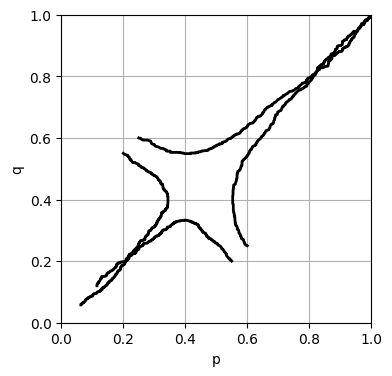

In [13]:
plt.figure(figsize=(4, 4)) # 図の設定
plt.xlabel('p') # x軸ラベル
plt.ylabel('q') # y軸ラベル
plt.xlim(0,1); plt.ylim(0,1)
singleRun(0.6,0.25)
singleRun(0.25,0.6)
singleRun(0.2,0.55)
singleRun(0.55,0.2)
plt.grid() # グリッド線
plt.show()

# 二つの描画を重ねてみる
（ここでは改めてそれぞれでシミュレーションの再計算をしてから描画しなおしているので、時間・計算の負荷が無駄にかかっています。既に描画したグラフ自体をどうにか取り出して(gcf?)、それをまた描画するだけにできれば、シミュレーションの計算はしなくて済むのですが。もしもよいお知恵がありましたら、私zusaiDpublic@gmail.comにお教えください。）

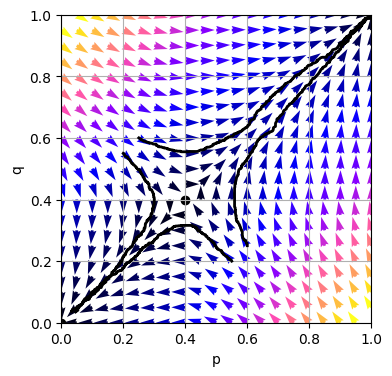

In [14]:
aggCust=AggPlayer(strgSet,payMat,dyn)
aggShop=AggPlayer(strgSet,payMat,dyn)
plt.figure(figsize=(4, 4)) # 図の設定
plt.xlabel('p') # x軸ラベル
plt.ylabel('q') # y軸ラベル
plt.xlim(0,1); plt.ylim(0,1)
phasePlot(aggCust.aggTrans_binary,aggShop.aggTrans_binary)
singleRun(0.6,0.25)
singleRun(0.25,0.6)
singleRun(0.2,0.55)
singleRun(0.55,0.2)
plt.grid() # グリッド線
plt.show()